## Model Evaluation - One vs Rest

Fitting models to data after performing feature selection. This notebook contains models and evaluation methods applicable to multiclass and binary classification problems, i.e problems where a given sample belongs to only one class. 

In [1]:
!conda install -y -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.6.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/chainer_p36

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libstdcxx-ng-7.3.0         |       hdf63c60_0         2.6 MB  conda-forge
    py-xgboost-0.81            |py36hf484d3e_1000          66 KB  conda-forge
    xgboost-0.81               |py36hf484d3e_1000           9 KB  conda-forge
    openssl-1.0.2p             |    h14c3975_1002         3.1 MB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    libxgboost-0.81            |    hf484d3e_1000         3.8 MB  conda-forge
    ----------------------------------------------

In [45]:
import pandas as pd
import numpy as np
import boto3
import s3fs
import os
import sys
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import xgboost as xgb
import warnings
import itertools
from scipy import stats
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Evaluator import Evaluator

Helper functions for evaluation and plotting

In [46]:
# Init class for model evaluation - detailed in Evaluation.py
ev = Evaluator()

Herer, we're reading in data that has already been run through the FeatureSelection.ipynb notebook. In order to read data from a different source, simply modify the filepaths below. You will have to split the data into training and test sets before running the remainder of the notebook. See `sklearn.preprocessing.train_test_split`.

In [4]:
# We read in a dataset that has already been feature selected
filepath = "s3://voightlab-data/t2d/FeatureSelected/chi2/"

X_train = pd.read_csv(filepath + "X_train.csv", index_col=0)
y_train = pd.read_csv(filepath + "y_train.csv", index_col=0)
X_test = pd.read_csv(filepath + "X_test.csv", index_col=0)
y_test = pd.read_csv(filepath + "y_test.csv", index_col=0)

In [5]:
X_train.head()
X_test.head()

,GSE64233_MED1_V_final.bed,H1-hESC_ChIP-seq_BACH1_ENCFF002CQP.bed,E114-H3K79me2.gappedPeak,HepG2_ChIP-seq_MAX_ENCSR000BTM_ENCFF001UGM_ENCFF001UGN_intersect.bed,GSE64233_p65_T_final.bed,GSM1208664_batch1_chrom1_LoVo_NR2F1_PassedQC_peaks_hg19.bed,WERI-Rb-1_ChIP-seq_H3K4me3_ENCSR000DXU_gappedpeak.bed,cardiac_mesoderm_ChIP-seq_H3K36me3_ENCSR000DSI_gappedpeak.bed,E127-H4K20me1.gappedPeak,HepG2_ChIP-seq_POLR2A_ENCFF002CUQ.bed,...,islets_h3k4me1_hg19_chipseq.bed,FAT.ADIP.NUC-EnhG,GSM1240819_GP5dControl_JUND_peaks_hg19.bed,E122-H3K9me1.gappedPeak,E122-H4K20me1.gappedPeak,GSE25836_Human_SGBS_Ads_PPARg_GLITR_1p5_FDR_hg19.bed,GSE64233_MED1_T_final.bed,GSE64233_DHS_V_final.bed,islet_H3K27ac.bed,PancIslt-EnhA
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [6]:
# Normalize the columns that are continuous to fall between 0 and 1
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [7]:
X_train.head()

,GSE64233_MED1_V_final.bed,H1-hESC_ChIP-seq_BACH1_ENCFF002CQP.bed,E114-H3K79me2.gappedPeak,HepG2_ChIP-seq_MAX_ENCSR000BTM_ENCFF001UGM_ENCFF001UGN_intersect.bed,GSE64233_p65_T_final.bed,GSM1208664_batch1_chrom1_LoVo_NR2F1_PassedQC_peaks_hg19.bed,WERI-Rb-1_ChIP-seq_H3K4me3_ENCSR000DXU_gappedpeak.bed,cardiac_mesoderm_ChIP-seq_H3K36me3_ENCSR000DSI_gappedpeak.bed,E127-H4K20me1.gappedPeak,HepG2_ChIP-seq_POLR2A_ENCFF002CUQ.bed,...,islets_h3k4me1_hg19_chipseq.bed,FAT.ADIP.NUC-EnhG,GSM1240819_GP5dControl_JUND_peaks_hg19.bed,E122-H3K9me1.gappedPeak,E122-H4K20me1.gappedPeak,GSE25836_Human_SGBS_Ads_PPARg_GLITR_1p5_FDR_hg19.bed,GSE64233_MED1_T_final.bed,GSE64233_DHS_V_final.bed,islet_H3K27ac.bed,PancIslt-EnhA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression

In [8]:
log_model = LogisticRegressionCV(solver='liblinear', 
                                 penalty='l1', 
                                 class_weight='balanced',
                                 scoring='roc_auc', 
                                 cv=10,
                                 max_iter=5000,
                                 n_jobs=-1)

log_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [9]:
print("Training Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_train, y_train, threshold=0.5)

Training Dataset Logistic Model Performance:
 Precision: 0.2575976845151954
 Recall: 0.5874587458745875
 Accuracy: 0.6991984912776992


In [10]:
print("Test Dataset Logistic", end=" ")
log_metrics = ev.summarize_performance(log_model, X_test, y_test, threshold=0.5, return_stats=True)

Test Dataset Logistic Model Performance:
 Precision: 0.24930747922437674
 Recall: 0.5921052631578947
 Accuracy: 0.6870300751879699


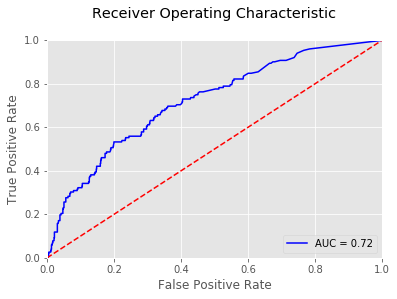

In [11]:
ev.plot_roc_curve(log_model, X_test, y_test)

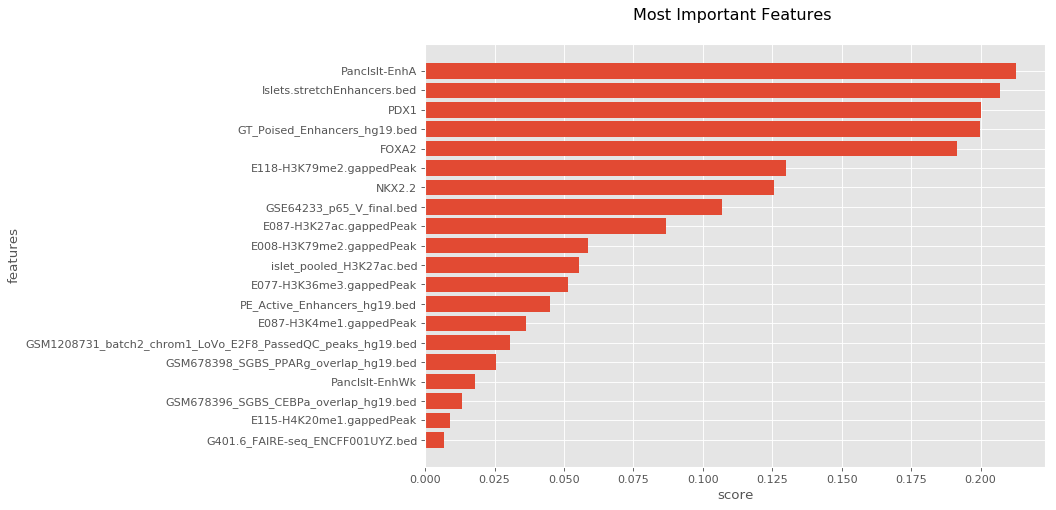

In [12]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)[0]

### Support Vector Machine 

In [13]:
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=5000)
svm_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=5000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_train, y_train, proba=False)

Training Dataset SVM Model Performance:
 Precision: 0.28133704735376047
 Recall: 0.6666666666666666
 Accuracy: 0.7090994813767091


In [15]:
print("Test Dataset SVM", end=" ")
svm_metrics = ev.summarize_performance(svm_model, X_test, y_test, threshold=0.5, return_stats=True)

Test Dataset SVM Model Performance:
 Precision: 0.0
 Recall: 0.0
 Accuracy: 0.8571428571428571


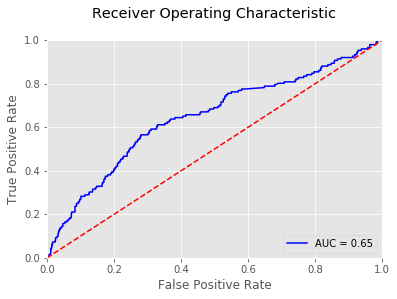

In [16]:
ev.plot_roc_curve(svm_model, X_test, y_test)

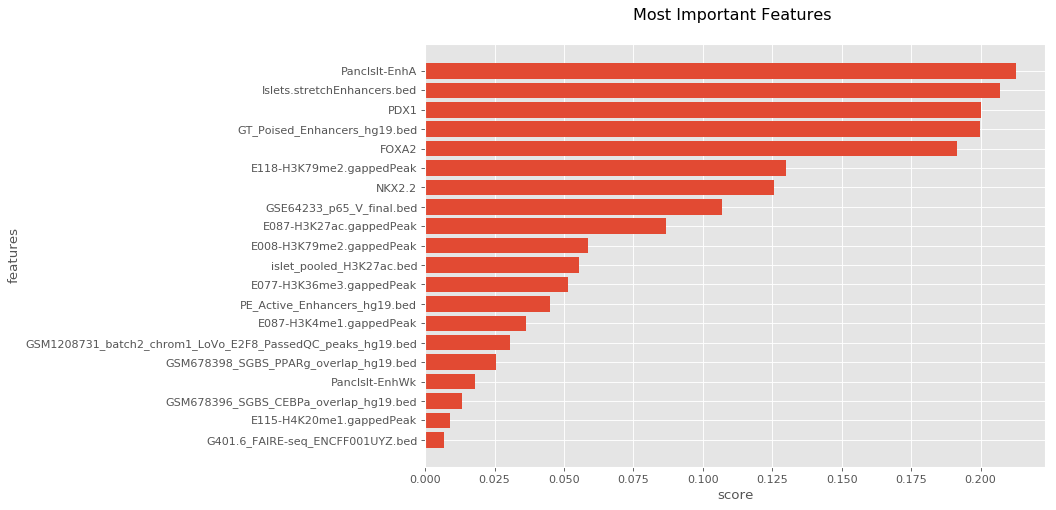

In [17]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)

### Random Forest

In [18]:
# n_jobs = -1 allows training to be done on all available cores
rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', oob_score=True)

# Parameter grid for grid search
rf_params = {'n_estimators': stats.randint.rvs(100, 1000, size=10),
			 'max_depth': stats.randint.rvs(2, len(X_train.columns) // 2, size=10), 
             'class_weight':['balanced', 'balanced_subsample']}

scoring = ['recall', 'roc_auc']

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

In [19]:
# Grid search to iteratively search parameter space
rf_grid = RandomizedSearchCV(rf_model, n_iter=100, param_distributions=rf_params,
                             cv=cv, scoring=scoring, refit='roc_auc')
rf_grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (rf_grid.best_params_, rf_grid.best_score_))

rf_grid_score = rf_grid.score(X_test, y_test)
print ("Grid search's score on new test data was {}".format(rf_grid_score))

The best parameters are {'n_estimators': 423, 'max_depth': 60, 'class_weight': 'balanced'} with a score of 0.62
Grid search's score on new test data was 0.6635539300554016


In [20]:
ev.summarize_performance(rf_grid, X_train, y_train, proba=True)

Model Performance:
 Precision: 0.9511400651465798
 Recall: 0.9636963696369637
 Accuracy: 0.9877416313059877


In [21]:
rf_metrics = ev.summarize_performance(rf_grid, X_test, y_test, proba=True, return_stats=True)

Model Performance:
 Precision: 0.125
 Recall: 0.013157894736842105
 Accuracy: 0.8458646616541353


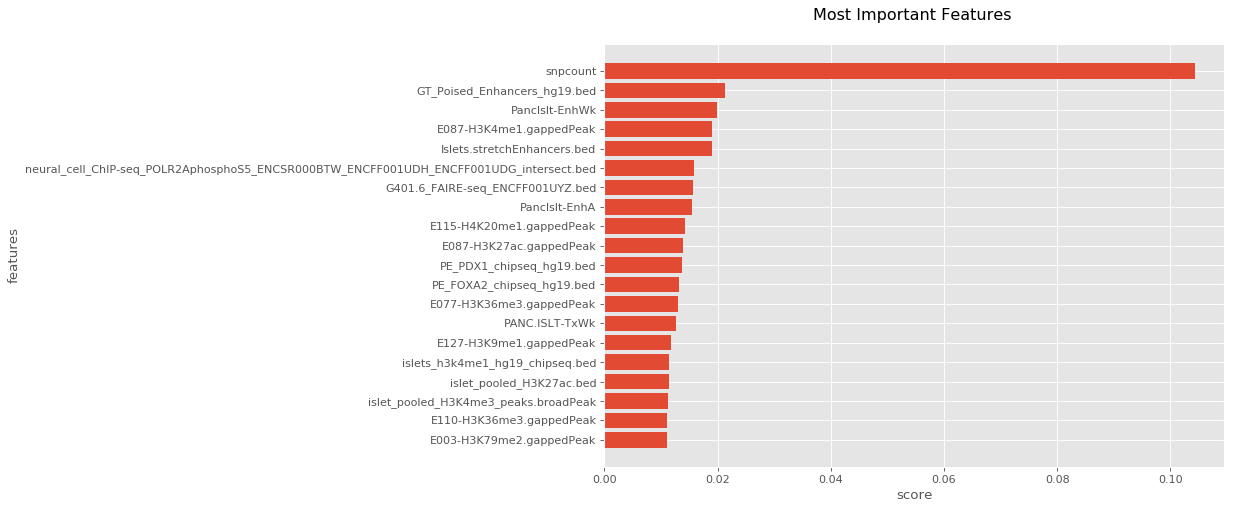

In [22]:
# Plot feature importance
coefs = rf_grid.best_estimator_.feature_importances_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=True)

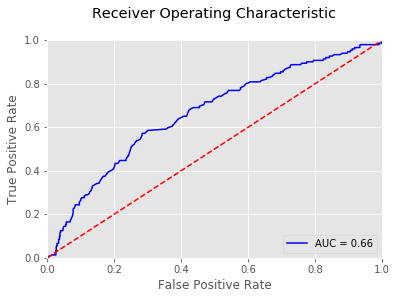

In [23]:
ev.plot_roc_curve(rf_grid, X_test, y_test)

### Gradient Boosted Trees

In [24]:
xgtrain = X_train.values
xgtrain_target = y_train.values
xgtest = X_test.values
xgtest_target = y_test.values

In [25]:
 # parameters to be tries in the grid search
cv_params = {'max_depth': [2, 3,5,7,10, 15, 20], 'min_child_weight': [1,2,3,4,5], 'scale_pos_weight':[2, 5, 7, 9]}   
#other parameters, fixed for the moment 
fix_params = {'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'binary:logistic','silent':1}   
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5)

In [26]:
# Trying to find best params for max depth and child weight
csv.fit(xgtrain, xgtrain_target)
csv.best_params_

{'max_depth': 2, 'min_child_weight': 5, 'scale_pos_weight': 2}

In [27]:
best_depth = csv.best_params_['max_depth']
best_child_weight = csv.best_params_['min_child_weight']
best_pos_weight = csv.best_params_['scale_pos_weight']

In [28]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 150, 'objective': 'binary:logistic',
              'max_depth': best_depth, 'min_child_weight':best_child_weight, 'scale_pos_weight':best_pos_weight}

In [29]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5) 
csv.fit(xgtrain, xgtrain_target)
csv.best_params_

{'max_delta_step': 1, 'subsample': 1}

In [30]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
fix_params['max_delta_step'] = csv.best_params_['max_delta_step']
fix_params['subsample'] = csv.best_params_['subsample']

In [31]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5) 
csv.fit(xgtrain, xgtrain_target)
csv.cv_results_
csv.best_params_

{'learning_rate': 0.05}

In [32]:
fix_params['learning_rate'] = csv.best_params_['learning_rate']
params_final =  fix_params
params_final['eval_metric'] = 'auc'
params_final['silent'] = 1
print(params_final)

{'learning_rate': 0.05, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 2, 'min_child_weight': 5, 'scale_pos_weight': 2, 'max_delta_step': 1, 'subsample': 1, 'eval_metric': 'auc', 'silent': 1}


In [33]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)

xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

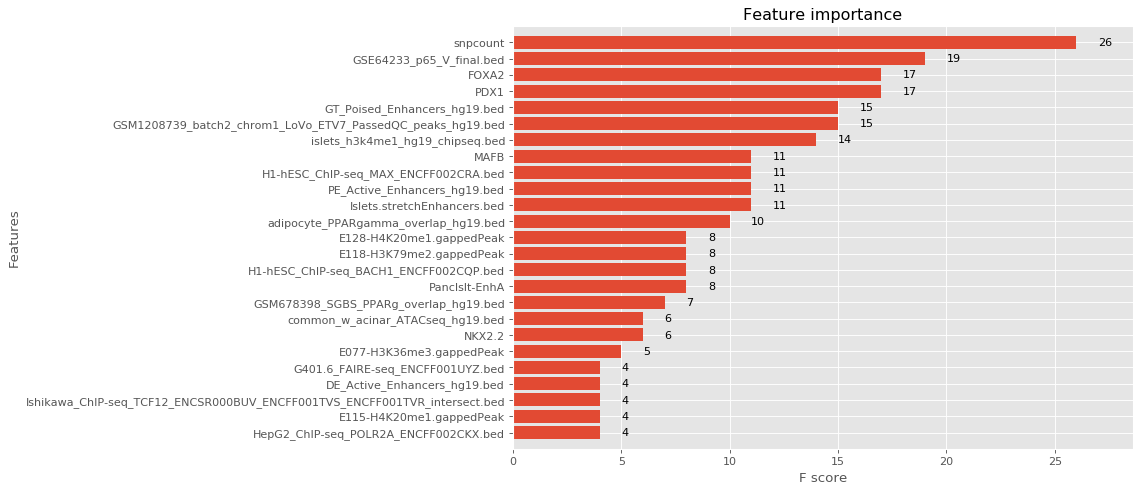

In [34]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10,7), dpi=80)
#  fig = plt.figure(num=None, figsize=(10, 7), dpi=80)
xgb.plot_importance(xgb_final, max_num_features=25, height=0.8, ax=ax)
plt.show()

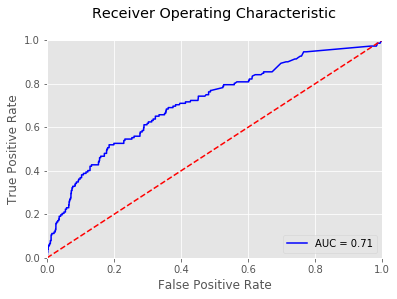

In [35]:
ev.plot_roc_curve(xgb_final, xgdmat_test, y_test, proba=False, model_type='xgboost')

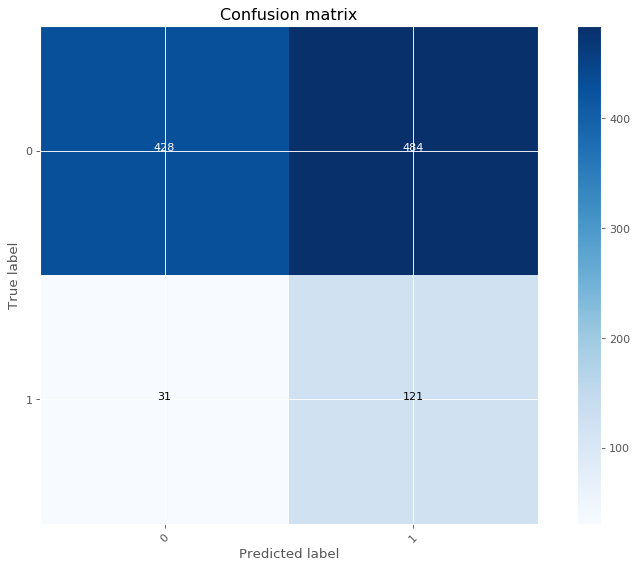

Precision =     0.200
Recall (TPR) =  0.796
Fallout (FPR) = 5.307e-01


In [36]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.19
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
ev.plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = ev.summarize_cmatrix(cm);

xgb_metrics = [pr, tpr, accuracy_score( y_test,y_pred)]

In [37]:
'''
These functions plot roc curves for model performance for each of the specified parameters to plot_roc.
Pass the name of the parameter to name_par and pass values to test to list_par
'''
def get_curves(X_train, y_train, X_val, y_val, pars):
    clf = xgb.XGBClassifier(**pars)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:,clf.classes_[1]]
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_prob)
    prec, rec, thresholds_pr = precision_recall_curve(y_val, y_prob)
    return fpr, tpr, prec, rec


def gen_curves(X_train, y_train, X_val, y_val, pars):
    N_iter = 300
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100000)
    
    mean_prec = 0.0
    mean_rec = np.linspace(0, 1, 100000)
    
    for n in range(N_iter):
        fpr, tpr, prec, rec = get_curves(X_train, y_train, X_val, y_val, pars)
        prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
        rec = list(reversed(rec))
        mean_tpr  += np.interp(mean_fpr, fpr, tpr)
        mean_prec += np.interp(mean_rec, rec, prec)

    mean_tpr /= N_iter
    mean_prec /= N_iter
    
    return mean_fpr, mean_tpr, mean_prec, mean_rec

In [38]:
def plot_roc(X_train, y_train, X_val, y_val, par, name_par, list_par):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,7));
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_train, y_train, X_val, y_val, par)
        ax1.plot(mean_fpr, mean_tpr, label = name_par+" = "+str(l))
        ax2.plot(mean_rec, mean_prec, label = name_par+" = "+str(l))
    ax1.set_xlim([0, 0.0005])
    ax1.set_ylim([0.5, 0.95])
    ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel('FPR/Fallout')
    ax1.set_ylabel('TPR/Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax1.set_title('ROC')
    ax2.set_title('PR')
    ax2.legend(loc = "lower left")
    ax2.set_xlim([0.5, 1])
    plt.show()

In [39]:
par = params_final
# plot_roc(xgtrain, xgtrain_target, xgtest, xgtest_target, par, 'max_depth', [3,4,5,7,10,15])

In [40]:
# Take a look at current params
par

{'learning_rate': 0.05,
 'n_estimators': 150,
 'objective': 'binary:logistic',
 'max_depth': 2,
 'min_child_weight': 5,
 'scale_pos_weight': 2,
 'max_delta_step': 1,
 'subsample': 1,
 'eval_metric': 'auc',
 'silent': 1}

In [41]:
par['max_depth'] = 3
par['learning_rate'] = 0.05
par['n_estimators'] = 200
par['scale_pos_weight'] = 6

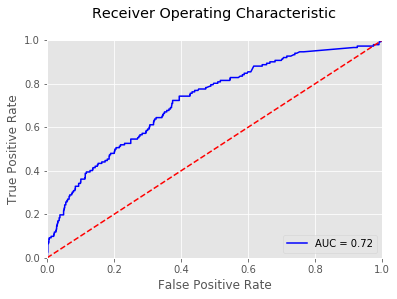

In [42]:
# Based on what we see with the graphs, re run xgboost with the params we think might help
xgb_final = xgb.train(par, xgdmat_train, num_boost_round = 100)
ev.plot_roc_curve(xgb_final, xgdmat_test, y_test, proba=False, model_type='xgboost')

### Model Comparison

Lets visualize summary statistics for each of the model types we've tried to see how they stack up to one another. To do this I've made use of the plot_compare method in Evaluator.py. More details on params are provided in the class file. 

In [43]:
results = [log_metrics, svm_metrics, rf_metrics, xgb_metrics]
labels = ["Precision", "Recall", "Accuracy"]
titles = ["Logistic Regression", "SVM", "Random Forest", "XGboost"]

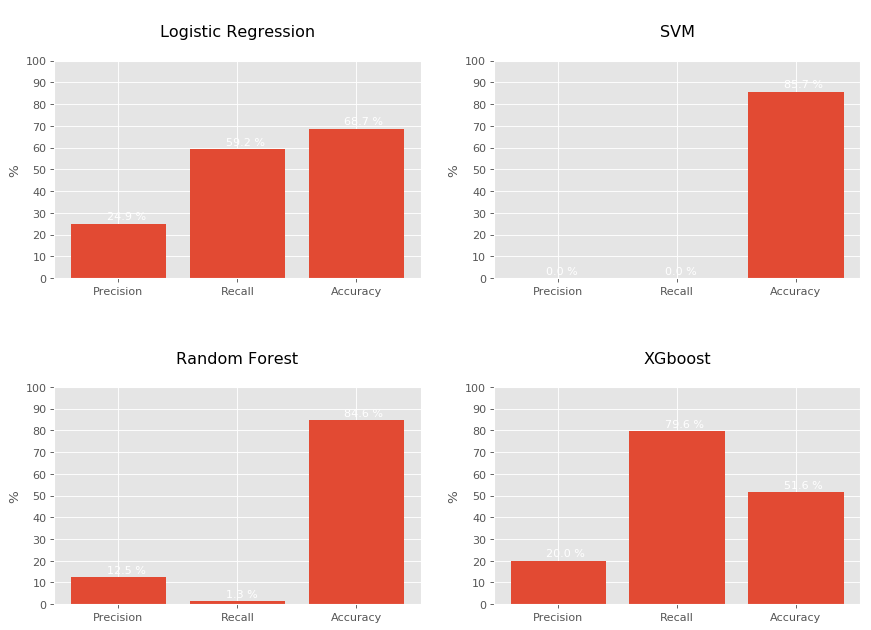

In [47]:
ev.plot_compare(results, labels, xlabel='Metrics', ylabel='%', titles=titles)